# Evaluate pseudotime goodness-of-fit by scDesign3

In this example, we will show how to use scDesign3 to evaluate the pseudotime goodness-of-fit for different pseudotime labels. If the true labels are unavailable and we have little prior knowledge, the scDesign3 BIC can serve as an unsupervised metric. In this tutorial, we will first use the R package `dyngen` to generate a dataset with ground truth "pseudotime". Then, we will perturb the ground truth pseudotime to worsen its quality and use scDesign3’s BIC to examine pseudotime goodness-of-fit.

## Generation of reference dataset & Simulation

We first generate a synthetic dataset with ground truth pseudotime using `dyngen` package in R. R is called in this jupyter notebook by `rpy2` package.

In [1]:
# pip install rpy2==3.6.1

In [2]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError("dlopen(/Users/pyl/anaconda3/envs/sc2/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <3D361A20-57F1-3C9B-9D2B-6A0F70CF5F35> /Users/pyl/anaconda3/envs/sc2/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.
/Users/pyl/anaconda3/envs/sc2/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/", R: "/Users/pyl/Desktop/UW Madis

In [3]:
%%R
library(scDesign3)
library(dyngen)
library(SingleCellExperiment)
library(ggplot2)
library(dplyr)
theme_set(theme_bw())

Registered S3 method overwritten by 'scDesign3':
  method         from  
  predict.gamlss gamlss
要求されたパッケージ SummarizedExperiment をロード中です
要求されたパッケージ MatrixGenerics をロード中です
要求されたパッケージ matrixStats をロード中です

次のパッケージを付け加えます: ‘MatrixGenerics’

以下のオブジェクトは ‘package:matrixStats’ からマスクされています:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins

In [4]:
%%R
set.seed(123)
backbone <- backbone_linear_simple()
config <-
  initialise_model(
    backbone = backbone,
    num_cells = 500,
    num_tfs = nrow(backbone$module_info),
    num_targets = 100,
    num_hks = 50,
    verbose = FALSE
  )
out <- generate_dataset(
  config,
  format = "sce",
  make_plots = FALSE
  )
example_sce <- out$dataset
colData(example_sce)$pseudotime <- out$model$experiment$cell_info$time 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 12% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s 

Then we convert the SingleCellExperiment object to an AnnData object in Python.


In [9]:
%%R
library(zellkonverter)
writeH5AD(example_sce, "data/pseudotime_example_sce.h5ad")

/Users/pyl/Library/Caches/org.R-project.R/R/basilisk/1.16.0/zellkonverter/1.14.1/zellkonverterAnnDataEnv-0.10.6/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
import anndata as ad
example_sce = ad.read_h5ad("data/pseudotime_example_sce.h5ad")
example_sce.X

<500x155 sparse matrix of type '<class 'numpy.float64'>'
	with 68069 stored elements in Compressed Sparse Column format>

Secondly, we perturb the pseudotime by generating random numbers from uniform distribution and replacing various percentages of the original pseudotime with random numbers. The percentage ranges from 0% to 100%. In the code below, we generate 11 sets of perturbed pseudotime with the percentage of perturbation ranging from 0% to 100%. For each new set of perturbed pseudotime, we create a new SingleCellExperiment object, storing the original count matrix and the corresponding perturbed pseudotime.

In [5]:
example_sce.obs.head()

,step_ix,simulation_i,sim_time,pseudotime
cell1,106,3,16.008333,0.263991
cell2,1169,27,44.008333,0.702819
cell3,1305,30,60.008333,0.988890
cell4,762,18,0.000000,0.027913
cell5,19,1,20.008333,0.383419


In [6]:
import numpy as np
import copy

np.random.seed(123)

original_pseudotime = example_sce.obs["pseudotime"].values

pertubed_sce_list = []

for x in range(10):
    perturb_prop = x/10
    n_cell = int(round(example_sce.n_obs * perturb_prop))
    
    cell_index = np.random.choice(example_sce.n_obs, size=n_cell, replace=False)
    
    new_pseudotime = original_pseudotime.copy()
    new_pseudotime[cell_index] = np.random.uniform(0, 1, n_cell)
    
    new_sce = example_sce.copy()
    new_sce.obs["pseudotime"] = new_pseudotime
    
    pertubed_sce_list.append(new_sce)

Thirdly, we iteratively use scDesign3 to estimate the pseudotime-based simulator.

Original R code:
```{r}
set.seed(123)
scDesign3_result <- lapply(example_sce_list, function(x) {
  res <-  scdesign3(
    sce = x,
    assay_use = "counts",
    celltype = NULL,
    pseudotime = "pseudotime",
    spatial = NULL,
    other_covariates = NULL,
    mu_formula = "s(pseudotime, bs = 'cr', k = 10)",
    sigma_formula = "1",
    corr_formula = "ind",
    copula = "gaussian",
    n_cores = 2
  )
  return(res)
})
```

In [7]:
from scdesigner.simulators import NegBinRegressionSimulator
import scipy

scdesign_result = []
for sce in pertubed_sce_list:
    if scipy.sparse.issparse(sce.X):
        sce.X = sce.X.toarray()
    sim = NegBinRegressionSimulator(batch_size=500)
    sim.fit(sce, "~ bs(pseudotime, degree=9)")
    scdesign_result.append(sim.marginal_bic) #.item()

scdesign_result

/Users/pyl/anaconda3/envs/sc2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/pyl/anaconda3/envs/sc2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/pyl/anaconda3/envs/sc2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/pyl/anaconda3/envs/sc2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/pyl/anaconda3/envs/sc2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `annda

[606164.5625,
 611458.0,
 614329.0625,
 617092.5625,
 617215.25,
 619269.0625,
 621128.3125,
 623667.0625,
 622908.3125,
 625887.1875]

In [8]:
from scipy.stats import pearsonr

# Assuming example_sce_list[0] and x are AnnData objects
pseudo1 = original_pseudotime
pseudo_list = [x.obs['pseudotime'].values for x in pertubed_sce_list]

r_squared = [pearsonr(pseudo1, pseudo2)[0]**2 for pseudo2 in pseudo_list]
r_squared

[1.0,
 0.8255787178672848,
 0.6894546242094374,
 0.48584447381233764,
 0.39854349451272686,
 0.36306905633442416,
 0.2108723345139283,
 0.11636269119725626,
 0.06822691443447863,
 0.022576431064499802]

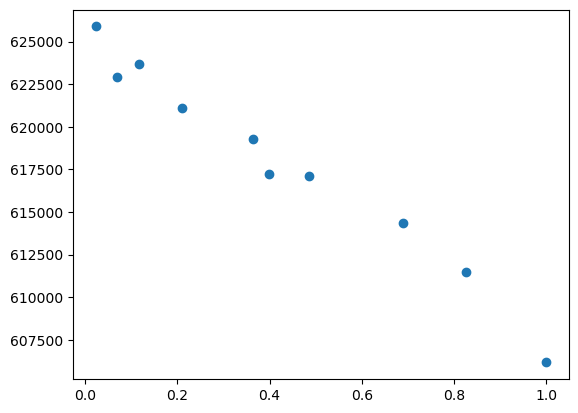

In [9]:
import matplotlib.pyplot as plt

plt.scatter(r_squared, scdesign_result)

We can see that the marginal BIC value agrees with the r-squared value.